## CS-E4740 - Federated Learning D (Spring 25)

# Assignment 4: FL Algorithms

### B. Zheng, A. Jung, and ChatGPT

<a id='varying_features'></a>
<div class="alert alert-warning">
    <h2>Deadline: 31.03.2025</h2>
</div>

<a id='varying_features'></a><div class="alert alert-info">

## Learning Goals
After completing the notebook, you should

- know the basic idea of decision tree,
- be able to implement FL network with non-parametric local models.


## Background Material

1. Chapter 5 of [FLBook](https://github.com/alexjungaalto/FederatedLearning/blob/main/material/FLBook.pdf)
2. [DecisionTreeRegressor in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

### Notebook Structure
1. The notebook consists of two parts: coding tasks (referred as Task) and quiz questions (referred as Question). 
2. Both Tasks and Questions are indexed with point-divided index X.Y, where X is the number of the notebook and Y is the number of the task/question in the X'th notebook.


## Importing necessary libraries

In [1]:
# General
import ast
import copy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

# Scikit-learn methods
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split


# We will use networx objects to store empirical graphs, local datasets and models
import networkx as nx 

RANDOM_STATE = 42


### Helper functions

In [2]:
def plotFMI(G, save_path=None):
    """
    Generates a scatter plot of FMI stations.

    Parameters
    ----------
    G : networkx.Graph
        A graph where each node represents an FMI station, 
        containing:
        - 'coord' (tuple: latitude, longitude) for spatial positioning.

    save_path : str, optional
        If provided, saves the plot to the specified file path.

    Returns
    -------
    None
        Displays a scatter plot of stations, where:
        - Nodes are plotted based on their geographic coordinates.
        - Node labels correspond to their index in the coordinate array.
    """
    # Extract coordinates
    coords = np.array([G.nodes[node]['coord'] for node in G.nodes])

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Draw nodes
    ax.scatter(coords[:, 1], coords[:, 0], c='black', s=50, zorder=5)

    # Add labels
    for node, (lat, lon) in enumerate(coords):
        ax.text(lon + 0.1, lat + 0.2, str(node), fontsize=8, ha='center', va='center', color='black', fontweight='bold')

    # Draw edges
    for u, v in G.edges:
        ax.plot([coords[u, 1], coords[v, 1]], [coords[u, 0], coords[v, 0]], linestyle='-', color='gray')

    # Set labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('FMI Stations')
    
    # Stretch according to Tissot's indicatrix
    ax.set_aspect(1.6)
    
    if save_path != None:
        try:
            plt.savefig(save_path)
        except IOError as e:
            print(f"Error saving plot: {e}")
            
    plt.show()
    
def add_edges(G, numneighbors=4):
    """Adds edges to a graph based on k-nearest neighbors using station coordinates.

    Parameters
    ----------
    G : networkx.Graph
        A graph where each node has a 'coord' attribute with (latitude, longitude).
    numneighbors : int, optional
        Number of nearest neighbors to connect to each node, by default 4.

    Returns
    -------
    networkx.Graph
        A new graph with added edges based on k-nearest neighbors.
    """
    # Deep copy the graph to avoid modifying the original
    graph_with_edges = copy.deepcopy(G)

    # Extract coordinates
    coords = np.array([graph_with_edges.nodes[node]['coord'] for node in graph_with_edges.nodes])

    # Create adjacency matrix using k-nearest neighbors
    adjacency_matrix = kneighbors_graph(coords, numneighbors, mode='connectivity', include_self=False)

    # Add edges based on the adjacency matrix
    edges = zip(*adjacency_matrix.nonzero())
    graph_with_edges.add_edges_from(edges)

    return graph_with_edges

## Get Data

We use the dataset stored in the file **'FMI_data_2025.csv'**. This dataset contains data points with the following properties(columns): 

- **Name**: The name of the weather station
- **Latitude**: The latitude of the weather station
- **Longitude**: The longitude of the weather station
- **Tmax**: The highest temperature recorded in the past five days
- **Tmin**: The lowest temperature recorded in the past five days
- **y_Tmax**: The highest temperature during a specific day
- **y_Tmin**: The lowest temperature during a specific day

Each station is uniquely identified by its name and represented as a node in the graph. And each station is a node in graph (we will build the graph later). 

Each row represents temperature data collected at a station over a 6-day window. The `Tmax` and `Tmin` values are based on the past 5 days, while `y_Tmax` corresponds to the highest temperature of the next day.

Briefly speaking, in each row, we use `Tmax` and `Tmin` to predict `y_Tmax`. The term 'min' and 'max' here just helping you to understand where these data come from. We will not use `y_Tmin` in this assignment.

One example that may help you understand:

<center>
<img src="Data-explain.png" alt="data-explain" width="80%"/>
</center>

In [3]:
# Import the weather measurements
data = pd.read_csv('FMI_data_2025.csv')

# Select and process relevant columns
data['X'] = data.apply(lambda row: row['Tmax'] + row['Tmin'], axis=1)
data['X'] = data['X'].apply(lambda row: ast.literal_eval(row.replace('][', ', ')))

# Get the number of the unique stations
n_stations = len(data.Name.unique())

# Display the first 5 entries
print(data.head())

                              Name  Latitude  Longitude  \
0  Jomala Maarianhamina lentoasema  60.12735   19.90038   
1  Jomala Maarianhamina lentoasema  60.12735   19.90038   
2  Jomala Maarianhamina lentoasema  60.12735   19.90038   
3  Jomala Maarianhamina lentoasema  60.12735   19.90038   
4  Jomala Maarianhamina lentoasema  60.12735   19.90038   

                          Tmax                            Tmin  y_Tmax  \
0  [0.3, -1.9, -1.2, 5.4, 7.7]   [-2.6, -4.9, -5.1, -9.6, 4.4]     7.1   
1    [6.4, 4.6, 3.1, 5.9, 6.3]      [4.4, 2.2, -1.5, 3.0, 5.1]     5.8   
2   [4.7, -2.1, 3.2, 4.5, 4.0]   [-2.6, -9.1, -9.2, -0.7, 0.5]     2.7   
3    [2.7, 0.9, 4.2, 2.7, 1.1]  [-3.4, -4.2, -2.1, -3.7, -7.8]     3.7   
4    [2.4, 5.8, 4.5, 4.8, 6.4]    [-2.0, -0.2, 2.5, -5.6, 3.6]     4.7   

   y_Tmin                                                  X  
0     5.7  [0.3, -1.9, -1.2, 5.4, 7.7, -2.6, -4.9, -5.1, ...  
1     4.0  [6.4, 4.6, 3.1, 5.9, 6.3, 4.4, 2.2, -1.5, 3.0,...  
2     0.7  


### Building a FMI Network


In [4]:
# Create a networkX graph
G_FMI_no_edges = nx.Graph()

# Add a one node per station
G_FMI_no_edges.add_nodes_from(range(0, n_stations))

for i, station in enumerate(data.Name.unique()):
    
    # Extract data of a certain station
    station_data = data[data.Name==station]
    
    X_node = station_data['X'].to_numpy().reshape(-1, 1)
    y_node = station_data['y_Tmax'].to_numpy().reshape(-1, 1)
    
    X_train, X_val, y_train, y_val = train_test_split(X_node, 
                                                        y_node, 
                                                        test_size=0.2, 
                                                        random_state=RANDOM_STATE)
    

    G_FMI_no_edges.nodes[i].update({
        'name': station,
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'weights': np.zeros((X_node.shape[1], 1)),
        'coord': (station_data.Latitude.iloc[0], station_data.Longitude.iloc[0]) # The coordinates of the i-th weather station
    })


# Add edges between each station and its nearest 4 neighbors.

G_FMI = add_edges(G_FMI_no_edges, numneighbors=4)

# NOTE: The empirical graph is connected with numneighbors=4
print("The empirical graph is connected:", nx.is_connected(G_FMI))


The empirical graph is connected: True


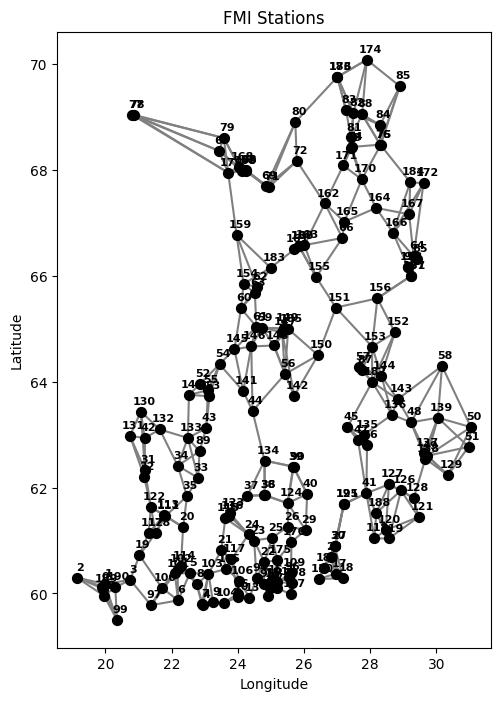

In [5]:
# Convert data type for X 
for node in G_FMI.nodes:
    X_train_obj = G_FMI.nodes[node]['X_train'] 
    X_train_array = np.array([row[0] for row in X_train_obj], dtype=float)
    G_FMI.nodes[node]['X_train'] = X_train_array
    
    X_val_obj = G_FMI.nodes[node]['X_val'] 
    X_val_array = np.array([row[0] for row in X_val_obj], dtype=float)
    G_FMI.nodes[node]['X_val'] = X_val_array

# Visualize the empirical graph
plotFMI(G_FMI)

## FedRelax

In Assignment 3, we learned about linear models. However, sometimes linear models are not convincing.

<center>
<img src="https://imgs.xkcd.com/comics/extrapolating.png" alt="Extrapolating" width="50%"/>
<br>
(image from [Extrapolating](https://xkcd.com/605/))
</center>

So next task is to explore non-linear local models and non-parametric local models.


### Parametric Models


Recall the GTVMin in 3.20 

$$\left\{\widehat{\mathbf{w}}^{(i)}\right\}_{i=1}^n \in \underset{\text { stack }\left\{\mathbf{w}^{(i)}\right\}_{i=1}^n}{\operatorname{argmin}} \sum_{i \in \mathcal{V}} L_i\left(\mathbf{w}^{(i)}\right)+\alpha \sum_{\left\{i, i^{\prime}\right\} \in \mathcal{E}} A_{i, i^{\prime}}\left\|\mathbf{w}^{(i)}-\mathbf{w}^{\left(i^i\right)}\right\|_2^2$$

We can decompose this objective function into $f^{(i)}(\mathbf{w})$ corresponding to each node $i$, where $f^{(i)}(\mathbf{w})$ contains local loss and neighbor regularization.

$$\widehat{\mathbf{w}} \in \underset{\mathbf{w} \in \mathbb{R}^{d \cdot n}}{\arg \min } \sum_{i \in \mathcal{V}} f^{(i)}(\mathbf{w})$$

with $f^{(i)}(\mathbf{w}):=L_i\left(\mathbf{w}^{(i)}\right)+(\alpha / 2) \sum_{i^{\prime} \in \mathcal{N}^{(i)}} A_{i, i^{\prime}}\left\|\mathbf{w}^{(i)}-\mathbf{w}^{\left(i^{\prime}\right)}\right\|_2^2$


Each $f^{(i)}$ involves only the parameters $\mathbf{w}^{(i)}$ of node $i$ and its neighbors $\mathcal{N}^{(i)}$. This means that while updating the model at node $i$, the contributions from distant nodes can be treated as fixed.

**Update rule: (Algorithm 5.8)**

<center>
<img src="FedRelax_Para.png" alt="FedRelax_Para" width="80%"/>
</center>

**5.24**:

<center>
<img src="Jacobi_update.png" alt="Jaccobi_update" width="80%"/>
</center>

At each iteration $k$, every neighbor node $i^\prime$ holds its current parameter estimate $\widehat{\mathrm{w}}_k^{(i^\prime)}$. The update for node $i$ is computed by solving:

$$
\widehat{\mathbf{w}}_{k+1}^{(i)} \in \underset{\mathbf{w}^{(i)} \in \mathbb{R}^d}{\operatorname{argmin}}\left[L_i\left(\mathbf{w}^{(i)}\right)+\alpha \sum_{i^{\prime} \in \mathcal{N}^{(i)}} A_{i, i^{\prime}}\left\|\mathbf{w}^{(i)}-\widehat{\mathbf{w}}_k^{\left(i^{\prime}\right)}\right\|_2^2\right]
$$

The update is done in parallel for all nodes. This is akin to the Jacobi algorithm in numerical analysis, where every block coordinates is updated simultaneously based on the current values of the other coordinates. The optimization variables are partitioned into blocks (here, each node’s parameters) and each block is updated while treating the others as constants.



### Non-parametric (or agnostic) model

In non-parametric model, we don't have a vector of parameters to perform optimization methods. A general update rule for each node $i$ is given by

$$
\widehat{h}_{k+1}^{(i)} \in \underset{h^{(0)} \in \mathcal{H}^{(0)}}{\operatorname{argmin}}\left\{L_i\left(h^{(i)}\right)+\alpha \sum_{i^{\prime} \in \mathcal{N}^{(i)}} A_{i, i^{\prime}} D\left(h^{(i)}, \widehat{h}_k^{\left(i^{\prime}\right)}\right)\right\} .
$$

Using square error loss, we can represent $D$ as :

$$D\left(h^{(i)}, h^{\left(i^{\prime}\right)}\right):=\left(1 / m^{\prime}\right) \sum_{\mathbf{x} \in \mathcal{D}^{\left\{i, i^{\prime}\right\}}}\left[h^{(i)}(\mathbf{x})-h^{\left(i^{\prime}\right)}(\mathbf{x})\right]^2$$

In essence, each node updates its local model by minimizing a combination of its own loss and a penalty for deviating from the models of its neighbors. $\widehat{h}_k^{\left(i^{\prime}\right)}$ means in each $k+1$ iteration, we consider adjacent nodes as fixed model from $k$ iteration.

**Update rule: (Algorithm 5.9)**

<center>
<img src="FedRelax_Agnostic.png" alt="FedRelax_Agnostic" width="80%"/>
</center>

**5.25**:

<center>
<img src="Agnostic_update.png" alt="Agnostic_update" width="80%"/>
</center>

**3.35**:

<center>
<img src="discrepancy.png" alt="discrepancy" width="80%"/>
</center>

<a id='varying_features'></a>
<div class=" alert alert-warning">
 
### Task 4.1 - Non-parametric Local Model -  Decision Tree

__Task description:__


Training process of Decision Tree:

1. Start at the root node with all training data.

2. Choose a feature that best splits the data into subgroups.

3. Repeat step 2 recursively on each subgroup until some stopping criterion is met.

Animation of Decision Tree:

<center>
<img src="DT_sine.gif" alt="Animation of Decision Tree" width="50%"/>
</center>

A decision tree is a greedy algorithm that does not use backpropagation and typically lacks an "intermediate state" for iterative training (some variants support online training, we employ the vanilla version for universality)

How can we train a decision tree in a federated style? 

Recall that the update rule:

$$\widehat{h}_{k+1}^{(i)} \in \underset{h^{(0)} \in \mathcal{H}^{(0)}}{\operatorname{argmin}}\left\{L_i\left(h^{(i)}\right)+\alpha \sum_{i^{\prime} \in \mathcal{N}^{(i)}} A_{i, i^{\prime}} D\left(h^{(i)}, \widehat{h}_k^{\left(i^{\prime}\right)}\right)\right\}$$

The first part is to achieve minimal local loss. 

The second part is to enhance the similarity between models of adjacent nodes. The similarity between models can be measured by comparing their outputs for identical inputs. To achieve this, we create an unlabeled "public data" set. Each node then utilizes "augmented data," which combines its original data with public data, where the labels for the public data are derived from predictions made by neighboring nodes.

<center>
<img src="Data_aug.png" alt="Data Augmentation" width="50%"/>
</center>

Define

$$
\mathcal{D}^{(i^\prime)}_\text{public}:=\left(X_\text{public},h^{(i^\prime)}(X_\text{public})\right)
$$


And

$$
\mathcal{D}^{(i,i^{\prime})}_{aug} := \mathcal{D}^{(i)} + \sum_{i^{\prime} \in \mathcal{N}^{(i)}}\mathcal{D}^{(i^{\prime})}_{public}
$$

Now we can update local model iteratively using Algorithm 5.9, where hypothesis $h$ is decision tree. 


__Hints:__

You can follow (but not necessary) the process below.

1. Train an initial tree solely on local data.
2. In each iteration and each node:
    - Build augmented data based on neighbors (you can average all neighbors' outputs as labels).
    - Train a new tree using augmented data.

!!! Always use `random_state = RANDOM_STATE` !!!

</div>

In [6]:
def fed_decision_tree(
    graph,
    max_iter=10,
    max_depth=5
):
    np.random.seed(RANDOM_STATE)
    G = copy.deepcopy(graph)

    # Create an unlabeled public dataset with uniform random values
    # -33, 12 are the lowest and highest temperature in our dataset respectively 
    X_public = np.random.uniform(low=-33, high=12, size=(10, 10))

    # Initialize each node's model on its local data (iteration k=0)
    for node in G.nodes:

        X_train = G.nodes[node]['X_train']
        y_train = G.nodes[node]['y_train']
        
        # store the decision tree regressor model trained on the local dataset in the node's attribute 'model'. 
        # G.nodes[node]['model'] <- DecisionTreeRegressor fitted on local data
        
        # !!! in DecisionTreeRegressor, use random_state = RANDOM_STATE (which is 42) !!!
        
        # YOUR CODE HERE
        # Train a decision tree regressor on local data
        reg_init = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_STATE)
        reg_init.fit(X_train, y_train)
        G.nodes[node]['model'] = reg_init

    # Iteratively update for k in [0...max_iter-1]
    for _ in range(max_iter):
        # We'll store newly trained models in a temporary dict so that 
        # we don't overwrite the old models before neighbors can read them.
        new_models = {}
        
        # For each node i, gather neighbors' predictions on X_public
        for node in G.nodes:
            neighbors = list(G.neighbors(node))
            
            # If no neighbors, we have no pseudo-labels
            if len(neighbors) == 0:
                # Just train on local data alone
                X_aug = G.nodes[node]['X_train']
                y_aug = G.nodes[node]['y_train']
            else:
                # Gather predictions from neighbors on X_public
                # Average the predictions across neighbors

                # YOUR CODE HERE
                y_public = np.zeros(X_public.shape[0])
                for neighbor in neighbors:
                    model = G.nodes[neighbor]['model']
                    y_public += model.predict(X_public)
                

                # concat X_local and X_public, store them as augmented feature data
                # X_aug <- concat(X_local, X_public)
                # concat y_local and y_public, store them as augmented label data
                # y_aug <- concat(y_local, y_public)
                
                # YOUR CODE HERE
                # Average the predictions across neighbors
                 
                y_public /= len(neighbors)

                # Ensure y_public is a column vector (shape: N x 1)
                y_public = y_public.reshape(-1, 1)

                # Concatenate X_local and X_public, store them as augmented feature data
                X_aug = np.vstack([G.nodes[node]['X_train'], X_public])

                # Concatenate y_local and y_public, store them as augmented label data
                y_aug = np.vstack([G.nodes[node]['y_train'].reshape(-1, 1), y_public])


            # Train a fresh tree on the augmented data
            reg_new = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_STATE)
            reg_new.fit(X_aug, y_aug)
            
            # Store in a local dict so we don't overwrite the old model
            new_models[node] = reg_new
        
        # Synchronize: update each node's model with the newly trained model
        for node in G.nodes:
            G.nodes[node]['model'] = new_models[node]

    # After max_iter iterations, each node's model is stored in G.nodes[node]['model'].
    return G



In [7]:
# We can achieve a small MSE in most stations.
# This is common in (naive) FL with heterogeneous data.
# You can adjust max_iter and max_depth to see the trade-off between local loss and global loss.
# With max_iter=10 and max_depth=5 and correct code, you can get avg_mse<50

# !!! SO KEEP max_iter=10 AND max_depth=5 WHEN YOU SUBMIT !!! 


G_dt = fed_decision_tree(
    G_FMI, 
    max_iter=10,
    max_depth=5
)


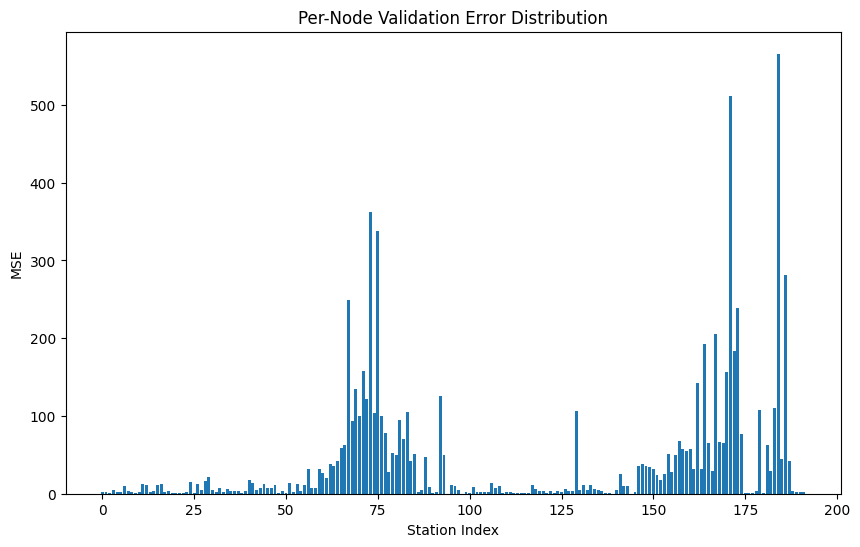

Average MSE: 38.97101978432444


In [8]:
# MSE results

mse_list = []
for node in G_dt.nodes():
    reg = G_dt.nodes[node]['model']
    X_val_local = G_dt.nodes[node]['X_val']
    y_val_local = G_dt.nodes[node]['y_val']
    y_pred = reg.predict(X_val_local)
    mse = mean_squared_error(y_val_local, y_pred)
    mse_list.append(mse)

plt.figure(figsize=(10, 6))
plt.bar(range(len(mse_list)), mse_list)
plt.title('Per-Node Validation Error Distribution')
plt.xlabel('Station Index')
plt.ylabel('MSE')
plt.show()

avg_mse = np.mean(mse_list)
print("Average MSE:", avg_mse)


In [9]:
# Sanity check
assert(avg_mse<50), "Try to achieve a better result."

print('Sanity check passed!')


Sanity check passed!


<a id='varying_features'></a>
<div class=" alert alert-warning">

### Question 4.1 - FedRelax

__Formulation:__

Why can't we use FedGD to train local decision tree models?
    
__Answer Options:__
    
1. Gradient descent is too costly in decision tree.
2. Decision tree does not rely on gradient-based optimization.
1. FedRelax is a superior algorithm to FedGD.

</div>

In [10]:
### Question ###

# Assign the variable to the answer option from the list above
# answer = ?

# YOUR CODE HERE
answer = 2

In [11]:
# Sanity checks

# Check if the chosen answer option is adequate
assert answer in [1, 2, 3], "Choose the answer option from the provided list."

print('Sanity check passed!')


Sanity check passed!


<a id='varying_features'></a>
<div class=" alert alert-warning">

### Question 4.2 - Scaling factor

__Formulation:__

What are the effects of using a large value for scaling factor $\alpha$?
    
__Answer Options:__
    
1. Using a large value for $\alpha$ puts more emphasis on learning local model parameters that do not vary too much across edges of the empirical graph.

2. The convergence is slower with larger $\alpha$-value.  

3. Using a large value for $\alpha$ results in local model parameters with small values for the local loss (training error) at the expense of relatively large variations of model parameters across edges of the empirical graph.  

4. Using a large value for $\alpha$ puts more emphasis on learning local model parameters with small local loss.  

5. Using a large value for $\alpha$ results in local model parameters with small total variation at the expense of higher values for the local loss (training error).

</div>

In [12]:
### Question ###

# Assign the variable to the answer option from the list above
# answer = {?, ?, ...}

# YOUR CODE HERE
answer = {5}


In [13]:
# Sanity checks

# Check if the chosen answer option is adequate
assert answer.issubset({1, 2, 3, 4, 5}), "Choose the answer options from the provided list."
assert isinstance(answer, set), "Answer type should be set."

print('Sanity check passed!')


Sanity check passed!
